In [1]:
import numpy as np 
from matplotlib import pyplot as plt

# Tax Simulator

The SRD is a tax simulator that can be downloaded easily using the tool pip. The documentation can be found here for the tax simulator: [https://creei-models.github.io/srd/](https://creei-models.github.io/srd/).  We only need to issue this line to install the tool in our google colab environment: 


In [2]:
!pip install srd

Defaulting to user installation because normal site-packages is not writeable


We import the module with

In [3]:
import srd

# Budget constraint

For a use case, we can compute the real budget constraint faced by a worker. The SRD accounts for more than 90% of tax spending measures at the federal and provincial level. Here we look at the case of a worker in 2019 earning 10 000$ in labor income. 

In [4]:
jean = srd.Person(earn=10e3)
case = srd.Hhold(jean)
tax = srd.tax(2019)

We compute his disposable income


In [5]:
case = tax.compute(case)

In [6]:
case.fam_disp_inc

14608.16

After computing disposable income, we see that it is higher than his labor income. This is because he is eligible to a number of transfers. Now look at his budget constraint:  


In [7]:
wage = 35.0
hours = np.linspace(0,60,100)

In [8]:
netinc = []
for h in hours: 
  jean = srd.Person(earn=wage*h*52)
  case = srd.Hhold(jean)
  case = tax.compute(case)
  netinc.append(case.fam_disp_inc)


We compute leisure, assuming 16 hours per day available for both work and leisure and 5 days a week. 


In [9]:
leisure = 5*16 - hours

We can now plot the budget constraint: 


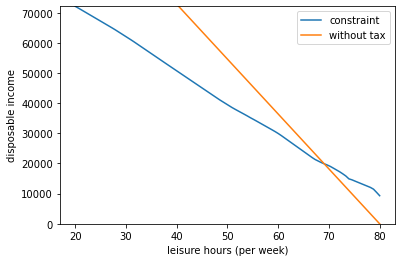

In [10]:
plt.figure()
plt.plot(leisure,netinc,label='constraint')
plt.plot(leisure,hours*wage*52,label='without tax')
plt.xlabel('leisure hours (per week)')
plt.ylabel('disposable income')
plt.ylim([0,max(netinc)])
plt.legend()
plt.show()

# EMTR

We can compute EMTRs, effective marginal tax rates. 

In [11]:
temis = []
for i,h in enumerate(hours[:-1]): 
   x = 1.0 - (netinc[i+1] - netinc[i])/(wage*(hours[i+1]-hours[i])*52) 
   temis.append(x)

We can plot EMTRs. We see that EMTRs are high at low levels of earnings. 


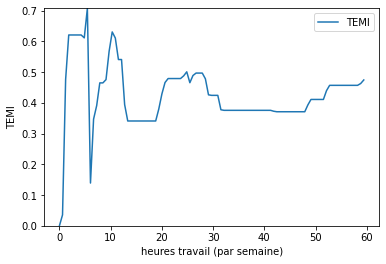

In [12]:
plt.figure()
plt.plot(hours[:-1],temis,label='TEMI')
plt.xlabel('heures travail (par semaine)')
plt.ylabel('TEMI')
plt.ylim([0,max(temis)])
plt.legend()
plt.show()

# Utility and Optimal Choice

We can implement an optimal choice solution. The first step is to specify a utility function

In [13]:
def u(c,h,phi,eps):
  g = 1 + + 1/eps
  return c - phi*(h**g) / g

Now fix a few parameters


In [14]:
eps = 1
phi = 1e-2

We can compute utility for a large number of hours worked. 


In [15]:
us = [u(c,h,phi,eps) for c,h in zip(netinc,hours*52)]

We see that utility is bell shaped. The consumer might want to pick the number of hours which maximize utility. 


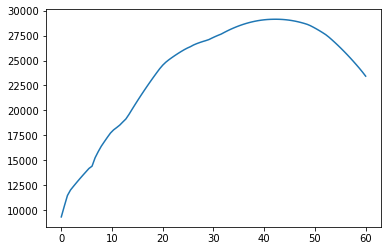

In [16]:
plt.figure()
plt.plot(hours,us)
plt.show()

We get the optimal choice by picking the maximum. 

In [17]:
hopt = hours[np.argmax(us)]

This yields

In [18]:
hopt

42.42424242424242

# Labor Supply

We can now trace labor supply. 

In [19]:
def supply(phi,eps,wage,tax):
  hours = np.linspace(0.0,80.0)
  netinc = []
  for h in hours: 
    p = srd.Person(earn=wage*h*52)
    case = srd.Hhold(p)
    case = tax.compute(case)
    netinc.append(case.fam_disp_inc)  
  us = [u(c,h,phi,eps) for c,h in zip(netinc,hours*52)]
  hopt = hours[np.argmax(us)]
  return hopt

In [20]:
wages = np.linspace(13.1,50.0,100)
sc = [supply(1e-2,1.0,w,tax) for w in wages]

We get a positive labor supply function with this utility function. The jumps are due to the discrete nature of our search for an optimum and the fact that the budget constraint as a few discrete changes as well. 


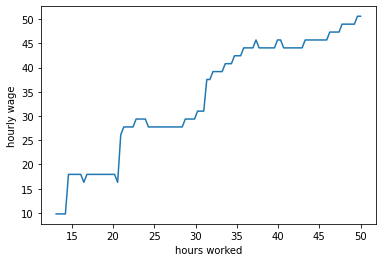

In [21]:
plt.figure()
plt.plot(wages,sc)
plt.xlabel('hours worked')
plt.ylabel('hourly wage')
plt.show()

# Changing tax rates

We can change income tax rates to see impacts on labor supply

In [22]:
tax2 = srd.tax(year=2019)

In [23]:
tax2.federal.l_rates = [t*1.25 for t in tax2.federal.l_rates]

In [24]:
tax2.federal.l_rates

[0.1875, 0.25625, 0.325, 0.3625, 0.41250000000000003]

In [25]:
href = supply(1e-2,1.0,wage,tax)
htax = supply(1e-2,1.0,wage,tax2)

Labor supply decreases by an average of 3 hours per week. 

In [26]:
href,htax

(42.44897959183673, 39.183673469387756)

The elasticity for this change is -0.3. This type of estimate is very useful to understand the impacts of changes in tax structures. 


In [27]:
eta = (htax/href-1)/0.25

In [28]:
eta

-0.3076923076923075